In [1]:
import os

In [ ]:
path = "./FaceForensics++_C23/"
csv_path = "csv"

LABELS = os.listdir(path)
LABELS.pop(0)
print(LABELS)

for label in LABELS:



['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']


In [1]:
import pandas as pd
from pathlib import Path

root = Path("FaceForensics++_C23")
meta = pd.read_csv(root / "csv" / "FF++_Metadata.csv")

print("Total rows in metadata:", len(meta))
print(meta['Label'].value_counts())

Total rows in metadata: 7000
Label
FAKE    6000
REAL    1000
Name: count, dtype: int64


In [3]:
from tqdm import tqdm  # pip install tqdm if needed

missing = []
for p in tqdm(meta['File Path']):
    if not (root / p).is_file():
        missing.append(p)

print("Missing files:", len(missing))
if missing:
    print(missing[:20])

100%|██████████| 7000/7000 [00:00<00:00, 12720.18it/s]

Missing files: 0


In [4]:
from collections import Counter
from pathlib import Path
import os
import pandas as pd
from tqdm import tqdm

root = Path("FaceForensics++_C23")
meta = pd.read_csv(root / "csv" / "FF++_Metadata.csv")

print("=== 1. Metadata summary ===")
print("Total videos in metadata:", len(meta))
print(meta["Label"].value_counts(), "\n")

print("=== 2. Check that all listed files exist ===")
missing = []
for rel in tqdm(meta["File Path"], desc="Checking files"):
    if not (root / rel).is_file():
        missing.append(rel)

print("Missing files:", len(missing))
if missing:
    print("Example missing paths:", missing[:10])
else:
    print("All metadata entries have a corresponding video file.\n")

print("=== 3. Count videos per top-level folder on disk ===")
folder_counts = {}
for entry in os.listdir(root):
    entry_path = root / entry
    if entry_path.is_dir() and entry != "csv":
        folder_counts[entry] = len([f for f in entry_path.iterdir() if f.is_file()])

for name, count in sorted(folder_counts.items()):
    print(f"{name:18s}: {count}")

print("\nNote: For binary classification, we typically map:")
print("  REAL  -> class 0 (real)")
print("  FAKE  -> class 1 (fake), i.e. all manipulated videos from all folders.")

=== 1. Metadata summary ===
Total videos in metadata: 7000
Label
FAKE    6000
REAL    1000
Name: count, dtype: int64 

=== 2. Check that all listed files exist ===


Checking files:   0%|          | 0/7000 [00:00<?, ?it/s]

Checking files: 100%|██████████| 7000/7000 [00:00<00:00, 13127.13it/s]



Missing files: 0
All metadata entries have a corresponding video file.

=== 3. Count videos per top-level folder on disk ===
DeepFakeDetection : 1000
Deepfakes         : 1000
Face2Face         : 1000
FaceShifter       : 1000
FaceSwap          : 1000
NeuralTextures    : 1000
original          : 1000

Note: For binary classification, we typically map:
  REAL  -> class 0 (real)
  FAKE  -> class 1 (fake), i.e. all manipulated videos from all folders.
DeepFakeDetection : 1000
Deepfakes         : 1000
Face2Face         : 1000
FaceShifter       : 1000
FaceSwap          : 1000
NeuralTextures    : 1000
original          : 1000

Note: For binary classification, we typically map:
  REAL  -> class 0 (real)
  FAKE  -> class 1 (fake), i.e. all manipulated videos from all folders.


In [5]:
# Count how many metadata rows per top-level folder
meta['top_folder'] = meta['File Path'].str.split('/').str[0]
print(meta.groupby(['top_folder', 'Label']).size())

top_folder         Label
DeepFakeDetection  FAKE     1000
Deepfakes          FAKE     1000
Face2Face          FAKE     1000
FaceShifter        FAKE     1000
FaceSwap           FAKE     1000
NeuralTextures     FAKE     1000
original           REAL     1000
dtype: int64


--------------------------------------------------

In [ ]:
# This cell is intentionally left empty.

## Step 1 – Build `selected_videos.csv` (full dataset, no subsampling)

We follow the pipeline: use **all** 1000 REAL + 6000 FAKE videos.

This CSV is the master list for later train/val/test splits.

In [1]:
from pathlib import Path

import pandas as pd



root = Path("FaceForensics++_C23")

meta = pd.read_csv(root / "csv" / "FF++_Metadata.csv")



# We simply keep all rows; REAL/FAKE is already in the Label column

selected_videos = meta.copy().reset_index(drop=True)

print("Selected videos (full dataset):", len(selected_videos))

print(selected_videos['Label'].value_counts())



out_path = root / "csv" / "selected_videos.csv"

selected_videos.to_csv(out_path, index=False)

print("Saved:", out_path)

Selected videos (full dataset): 7000
Label
FAKE    6000
REAL    1000
Name: count, dtype: int64
Saved: FaceForensics++_C23\csv\selected_videos.csv


## Step 2 – Split into train / val / test at **video level**

We do a stratified split by `Label` (REAL vs FAKE) with a 70 / 15 / 15 ratio as in the pipeline.

In [2]:
from pathlib import Path

import pandas as pd

from sklearn.model_selection import train_test_split



root = Path("FaceForensics++_C23")

selected_path = root / "csv" / "selected_videos.csv"

selected_videos = pd.read_csv(selected_path)



# Ensure Label is treated as string

selected_videos['Label'] = selected_videos['Label'].astype(str)



train_df, temp_df = train_test_split(

    selected_videos,

    test_size=0.30,

    stratify=selected_videos['Label'],

    random_state=42

)



val_df, test_df = train_test_split(

    temp_df,

    test_size=0.50,  # 0.5 of 30% -> 15% each

    stratify=temp_df['Label'],

    random_state=42

)



print("Train size:", len(train_df))

print(train_df['Label'].value_counts())

print("\nVal size:", len(val_df))

print(val_df['Label'].value_counts())

print("\nTest size:", len(test_df))

print(test_df['Label'].value_counts())



train_path = root / "csv" / "train_videos.csv"

val_path = root / "csv" / "val_videos.csv"

test_path = root / "csv" / "test_videos.csv"



train_df.to_csv(train_path, index=False)

val_df.to_csv(val_path, index=False)

test_df.to_csv(test_path, index=False)



print("Saved:")

print("  ", train_path)

print("  ", val_path)

print("  ", test_path)

Train size: 4900
Label
FAKE    4200
REAL     700
Name: count, dtype: int64

Val size: 1050
Label
FAKE    900
REAL    150
Name: count, dtype: int64

Test size: 1050
Label
FAKE    900
REAL    150
Name: count, dtype: int64
Saved:
   FaceForensics++_C23\csv\train_videos.csv
   FaceForensics++_C23\csv\val_videos.csv
   FaceForensics++_C23\csv\test_videos.csv


## Step 3 – Compute class weights for REAL/FAKE (for loss)

We compute inverse-frequency weights from the **train** split to use later in `CrossEntropyLoss`.

In [3]:
import pandas as pd

from pathlib import Path

import torch



root = Path("FaceForensics++_C23")

train_df = pd.read_csv(root / "csv" / "train_videos.csv")



label_counts = train_df['Label'].value_counts().to_dict()

print("Label counts in train split:", label_counts)



# Map REAL->0, FAKE->1

num_real = label_counts.get('REAL', 0)

num_fake = label_counts.get('FAKE', 0)

total = num_real + num_fake



# Inverse-frequency style weights (higher for minority class REAL)

w_real = total / (2.0 * max(num_real, 1))

w_fake = total / (2.0 * max(num_fake, 1))



class_weights = torch.tensor([w_fake, w_real], dtype=torch.float32)

print("Class weights (FAKE, REAL):", class_weights)

Label counts in train split: {'FAKE': 4200, 'REAL': 700}
Class weights (FAKE, REAL): tensor([0.5833, 3.5000])


## Step 4 – Helper to compute sampled frame indices per video

We follow the pipeline: ~1 fps sampling, capped at `max_frames_per_video` (e.g. 40).

In [4]:
def compute_sampled_indices(frame_count, assumed_fps=25, max_frames_per_video=40):

    """Return list of frame indices to sample given total frame_count.



    - step ~ 1 fps -> step = assumed_fps

    - start from `step` to avoid very first frames

    - cap the number of frames by max_frames_per_video

    """

    if frame_count <= 0:

        return []



    step = int(assumed_fps)

    if step <= 0:

        step = 1



    start = step  # skip the very first second

    indices = list(range(start, frame_count, step))



    if len(indices) > max_frames_per_video:

        indices = indices[:max_frames_per_video]

    return indices



# Quick sanity checks

for F in [300, 600, 1200]:

    idx = compute_sampled_indices(F)

    print(f"F={F}, num_frames={len(idx)}, first={idx[:3]} last={idx[-3:] if idx else []}")

F=300, num_frames=11, first=[25, 50, 75] last=[225, 250, 275]
F=600, num_frames=23, first=[25, 50, 75] last=[525, 550, 575]
F=1200, num_frames=40, first=[25, 50, 75] last=[950, 975, 1000]


## Step 5 – Extract and save sampled frames with OpenCV

We now implement frame extraction to `data_frames/{split}/{REAL|FAKE}/...` according to the pipeline.

In [5]:
import cv2

import os

from pathlib import Path

from tqdm import tqdm



data_frames_root = Path("data_frames")

data_frames_root.mkdir(exist_ok=True)



def extract_frames_for_split(split_name, csv_name, max_frames_per_video=40, assumed_fps=25, target_size=(224, 224)):

    """Extract sampled frames for all videos in the given split.



    Saves images under data_frames/{split}/{REAL|FAKE}/filename_fXXXX.png

    """

    split_root = data_frames_root / split_name

    (split_root / "REAL").mkdir(parents=True, exist_ok=True)

    (split_root / "FAKE").mkdir(parents=True, exist_ok=True)



    df = pd.read_csv(root / "csv" / csv_name)



    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Extracting {split_name}"):

        rel_path = row["File Path"]

        label = row["Label"]  # 'REAL' or 'FAKE'

        frame_count = int(row.get("Frame Count", -1))



        video_path = root / rel_path

        if not video_path.is_file():

            continue



        # Compute which frame indices to sample

        indices = compute_sampled_indices(frame_count, assumed_fps=assumed_fps, max_frames_per_video=max_frames_per_video)

        if not indices:

            continue



        cap = cv2.VideoCapture(str(video_path))

        if not cap.isOpened():

            continue



        base_name = video_path.stem  # file name without extension



        for idx in indices:

            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)

            ret, frame = cap.read()

            if not ret:

                continue



            # BGR -> RGB (optional) then resize

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frame = cv2.resize(frame, target_size)



            out_dir = split_root / label  # REAL or FAKE

            frame_filename = f"{base_name}_f{idx:05d}.png"

            out_path = out_dir / frame_filename

            cv2.imwrite(str(out_path), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))



        cap.release()



# WARNING: This can take a long time. Uncomment one line at a time.

# extract_frames_for_split("train", "train_videos.csv")

# extract_frames_for_split("val", "val_videos.csv")

# extract_frames_for_split("test", "test_videos.csv")

## Step 6 – Quick sanity check of extracted images

List some files from `data_frames/train/REAL` and `data_frames/train/FAKE`.

In [6]:
from pathlib import Path

import itertools



train_real_dir = Path("data_frames/train/REAL")

train_fake_dir = Path("data_frames/train/FAKE")



def list_some_images(directory, max_files=5):

    if not directory.exists():

        print(f"{directory} does not exist")

        return

    files = list(itertools.islice((p for p in directory.iterdir() if p.is_file()), max_files))

    print(f"Directory: {directory}")

    for p in files:

        print("  ", p.name)

    if not files:

        print("  (no files found)")



list_some_images(train_real_dir)

print()

list_some_images(train_fake_dir)

Directory: data_frames\train\REAL
   001_f00025.png
   001_f00050.png
   001_f00075.png
   001_f00100.png
   001_f00125.png

Directory: data_frames\train\FAKE
   000_003_f00025.png
   000_003_f00050.png
   000_003_f00075.png
   000_003_f00100.png
   000_003_f00125.png


## Step 7 – PyTorch `ImageFolder` datasets and DataLoaders

We now load `data_frames/{train,val,test}/{REAL,FAKE}` using torchvision’s `ImageFolder`.

In [7]:
import torch

from torch.utils.data import DataLoader

from torchvision import datasets, transforms



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)



data_dir = Path("data_frames")



# ImageNet mean/std for pretrained CNNs

imagenet_mean = [0.485, 0.456, 0.406]

imagenet_std = [0.229, 0.224, 0.225]



# Stronger augmentation to help generalization

train_transform = transforms.Compose([

    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),

    transforms.RandomHorizontalFlip(),

    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.08),

    transforms.RandomRotation(degrees=10),

    transforms.ToTensor(),

    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),

])



eval_transform = transforms.Compose([

    transforms.Resize(256),

    transforms.CenterCrop(224),

    transforms.ToTensor(),

    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),

])



train_dataset = datasets.ImageFolder(root=str(data_dir / "train"), transform=train_transform)

val_dataset = datasets.ImageFolder(root=str(data_dir / "val"), transform=eval_transform)

test_dataset = datasets.ImageFolder(root=str(data_dir / "test"), transform=eval_transform)



print("Classes:", train_dataset.classes)

print("Train images:", len(train_dataset))

print("Val images:", len(val_dataset))

print("Test images:", len(test_dataset))



# Slightly smaller batch size can also help generalization

batch_size = 64



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



len(train_loader), len(val_loader), len(test_loader)

Using device: cuda
Classes: ['FAKE', 'REAL']
Train images: 53996
Val images: 17380
Test images: 17986


(844, 272, 282)

## Step 8 – Define ResNet model, loss (with class weights), and optimizer

We use a pretrained ResNet backbone and adapt the final layer for 2 classes (REAL vs FAKE).

In [8]:
import torch.nn as nn

from torchvision import models



# Reuse class_weights from earlier cell if available; otherwise set to None

try:

    cw = class_weights.to(device)

except NameError:

    cw = None

    print("Warning: class_weights not found; using unweighted loss.")



def create_model(num_classes=2, use_pretrained=True):

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if use_pretrained else None)

    in_features = model.fc.in_features

    # Add a small dropout before the final layer to reduce overfitting

    model.fc = nn.Sequential(

        nn.Dropout(p=0.3),

        nn.Linear(in_features, num_classes),

    )

    return model



model = create_model(num_classes=2, use_pretrained=True).to(device)



criterion = nn.CrossEntropyLoss(weight=cw)



# Use weight decay for regularization

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)



# Add a simple learning-rate scheduler that reduces LR when val loss plateaus (configured later)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)



print(model.fc)

criterion, optimizer, scheduler

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=512, out_features=2, bias=True)
)


(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0001
     maximize: False
     weight_decay: 0.0001
 ),
 <torch.optim.lr_scheduler.ReduceLROnPlateau at 0x210192351d0>)

## Step 9 – Training and validation loop

We train for a few epochs, track loss/accuracy on train/val, and keep the best model by val accuracy.

In [9]:
import time



def train_one_epoch(model, loader, optimizer, criterion, device):

    model.train()

    running_loss = 0.0

    running_corrects = 0

    total = 0



    for inputs, labels in loader:

        inputs = inputs.to(device)

        labels = labels.to(device)



        optimizer.zero_grad()



        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()



        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels).item()

        total += inputs.size(0)



    epoch_loss = running_loss / total

    epoch_acc = running_corrects / total

    return epoch_loss, epoch_acc





@torch.no_grad()

def evaluate(model, loader, criterion, device):

    model.eval()

    running_loss = 0.0

    running_corrects = 0

    total = 0



    for inputs, labels in loader:

        inputs = inputs.to(device)

        labels = labels.to(device)



        outputs = model(inputs)

        loss = criterion(outputs, labels)



        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels).item()

        total += inputs.size(0)



    epoch_loss = running_loss / total

    epoch_acc = running_corrects / total

    return epoch_loss, epoch_acc





num_epochs = 20  # adjust as needed, e.g. 20-40 for full training

best_val_acc = 0.0

best_state_dict = None



history = {

    "train_loss": [],

    "train_acc": [],

    "val_loss": [],

    "val_acc": [],

}



for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    elapsed = time.time() - start_time



    history["train_loss"].append(train_loss)

    history["train_acc"].append(train_acc)

    history["val_loss"].append(val_loss)

    history["val_acc"].append(val_acc)



    # Step LR scheduler based on validation loss

    scheduler.step(val_loss)



    print(f"Epoch {epoch+1}/{num_epochs} | "

          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "

          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, "

          f"time={elapsed:.1f}s")



    if val_acc > best_val_acc:

        best_val_acc = val_acc

        best_state_dict = model.state_dict()



print("Best val acc:", best_val_acc)



if best_state_dict is not None:

    model.load_state_dict(best_state_dict)

    torch.save(model.state_dict(), "best_resnet_ffpp_binary.pth")

    print("Saved best model to best_resnet_ffpp_binary.pth")

Epoch 1/20 | train_loss=0.4157, train_acc=0.6506, val_loss=0.7457, val_acc=0.5299, time=192.5s
Epoch 2/20 | train_loss=0.3363, train_acc=0.7380, val_loss=0.8791, val_acc=0.5659, time=168.0s
Epoch 3/20 | train_loss=0.2940, train_acc=0.7794, val_loss=1.1368, val_acc=0.5497, time=165.4s
Epoch 4/20 | train_loss=0.2418, train_acc=0.8231, val_loss=1.1738, val_acc=0.6030, time=170.4s
Epoch 5/20 | train_loss=0.2228, train_acc=0.8392, val_loss=1.3292, val_acc=0.5761, time=177.5s
Epoch 6/20 | train_loss=0.1977, train_acc=0.8577, val_loss=1.4350, val_acc=0.6113, time=183.1s
Epoch 7/20 | train_loss=0.1847, train_acc=0.8664, val_loss=1.4507, val_acc=0.5979, time=187.5s
Epoch 8/20 | train_loss=0.1753, train_acc=0.8741, val_loss=1.6310, val_acc=0.6085, time=177.8s
Epoch 9/20 | train_loss=0.1653, train_acc=0.8802, val_loss=1.7134, val_acc=0.6089, time=184.2s
Epoch 10/20 | train_loss=0.1594, train_acc=0.8860, val_loss=1.7358, val_acc=0.6143, time=191.2s
Epoch 11/20 | train_loss=0.1530, train_acc=0.8906

## Step 10 – Test set evaluation

Evaluate the best saved model on the held-out test frames and report accuracy.

In [10]:
@torch.no_grad()

def evaluate_simple(model, loader, device):

    model.eval()

    correct = 0

    total = 0

    for inputs, labels in loader:

        inputs = inputs.to(device)

        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        correct += torch.sum(preds == labels).item()

        total += inputs.size(0)

    return correct / total if total > 0 else 0.0



# If you restarted the kernel, reload weights before testing:

# model = create_model(num_classes=2, use_pretrained=False).to(device)

# model.load_state_dict(torch.load("best_resnet_ffpp_binary.pth", map_location=device))



test_acc = evaluate_simple(model, test_loader, device)

print("Test accuracy:", test_acc)

Test accuracy: 0.7635939063716224


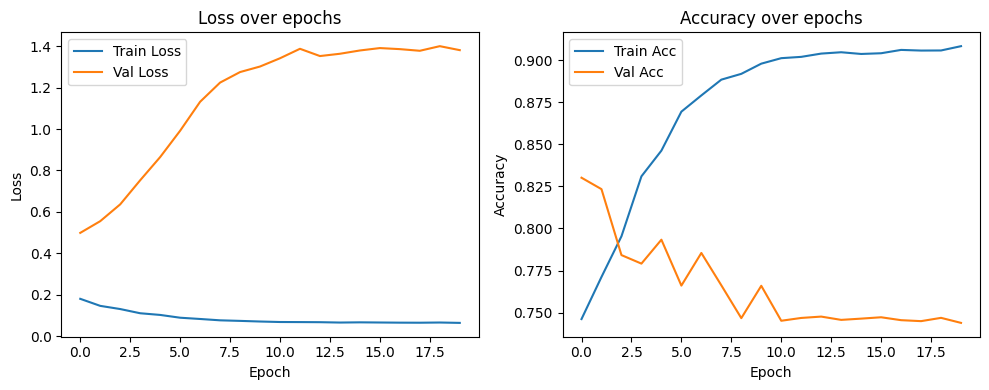

Confusion Matrix (rows=true, cols=pred):
[[13413  1747]
 [ 2505   321]]

Classification Report:
              precision    recall  f1-score   support

        FAKE     0.8426    0.8848    0.8632     15160
        REAL     0.1552    0.1136    0.1312      2826

    accuracy                         0.7636     17986
   macro avg     0.4989    0.4992    0.4972     17986
weighted avg     0.7346    0.7636    0.7482     17986



In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()

plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

@torch.no_grad()
def get_predictions_and_labels(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

# Get predictions on the test set
y_pred, y_true = get_predictions_and_labels(model, test_loader, device)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

# Per-class precision/recall/F1tif
target_names = train_dataset.classes  # ["REAL", "FAKE"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))